In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import load, dump
import matplotlib.pyplot as plt


from molmap import loadmap
from molmap.model import RegressionEstimator, MultiClassEstimator, MultiLabelEstimator
from molmap import loadmap, dataset
from molmap.show import imshow_wrap
import molmap
import os



## build model by optimized feature parameters only, other parameters remain default

In [2]:
## fix random seed to get repeatale results
seed = 123
tqdm.pandas(ascii=True)
np.random.seed(seed)

from chembench import dataset, load_data
#load dataset
data = dataset.load_BACE()
df = data.df
Y = data.y
task_name = data.task_name


total samples: 1513


In [3]:
train_df = pd.read_csv('../data/train.csv')
valid_df = pd.read_csv('../data/val.csv')
test_df = pd.read_csv('../data/test.csv')


train_idx = df[df.smiles.isin(train_df.smiles)].index
valid_idx = df[df.smiles.isin(valid_df.smiles)].index
test_idx = df[df.smiles.isin(test_df.smiles)].index

len(train_idx), len(valid_idx), len(test_idx)

(1210, 151, 152)

## load optimized molmaps

In [4]:
### optimized hyper-parameters
n_neighbors = 15
min_dist = 0.75

task_name = data.task_name
_, induces = load_data(task_name)


mp2 = molmap.loadmap('../../fingerprint.mp')
mp2.fit(method = 'umap', min_dist = min_dist, n_neighbors = n_neighbors)

loading dataset: BACE number of split times: 3
UMAP(metric='precomputed', min_dist=0.75, random_state=1, verbose=2)
Construct fuzzy simplicial set
Mon Sep 21 16:02:49 2020 Finding Nearest Neighbors
Mon Sep 21 16:02:49 2020 Finished Nearest Neighbor Search
Mon Sep 21 16:02:51 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Sep 21 16:02:57 2020 Finished embedding
2020-09-21 16:02:57,066 - INFO - [bidd-molmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2020-09-21 16:02:59,939 - INFO - [bidd-molmap] - Finished


In [ ]:
mp2.save('../optimized_fingerprint.mp')

In [6]:
_ = mp2.plot_grid()
_ = mp2.plot_scatter()

2020-09-21 13:46:43,021 - INFO - [bidd-molmap] - generate file: ./fingerprint_1303_cosine_umap_molmap
2020-09-21 13:46:43,073 - INFO - [bidd-molmap] - save html file to ./fingerprint_1303_cosine_umap_molmap
2020-09-21 13:46:43,074 - INFO - [bidd-molmap] - generate file: ./fingerprint_1303_cosine_umap_scatter
2020-09-21 13:46:43,113 - INFO - [bidd-molmap] - save html file to ./fingerprint_1303_cosine_umap_scatter


In [7]:
X2 = mp2.batch_transform(df.smiles, n_jobs = 8)

100%|##########| 1513/1513 [00:50<00:00, 29.71it/s]


In [8]:
trainX = X2[train_idx]
trainY = Y[train_idx]

validX = X2[valid_idx]
validY = Y[valid_idx]

testX = X2[test_idx]
testY = Y[test_idx]

In [9]:
### optimized hyper-parameters

clf = MultiLabelEstimator(n_outputs = 1,
                          fmap_shape1 = trainX.shape[1:],
                          batch_size = 128, 
                          lr = 1e-3, 
                          dense_layers = [128, 32],
                          gpuid = "3", 
                          monitor = 'val_auc',
                          )             

clf.fit(trainX, trainY, validX, validY) 

MultiLabelEstimator(dense_layers=[128, 32], gpuid='3', lr=0.001,
                    monitor='val_auc')
epoch: 0001, loss: 0.7023 - val_loss: 0.6928; auc: 0.7821 - val_auc: 0.7349                                                                                                    
epoch: 0002, loss: 0.6835 - val_loss: 0.6847; auc: 0.7910 - val_auc: 0.7435                                                                                                    
epoch: 0003, loss: 0.6599 - val_loss: 0.6575; auc: 0.7918 - val_auc: 0.7658                                                                                                    
epoch: 0004, loss: 0.6228 - val_loss: 0.6054; auc: 0.8321 - val_auc: 0.7834                                                                                                    
epoch: 0005, loss: 0.5528 - val_loss: 0.6477; auc: 0.8592 - val_auc: 0.7998                                                                                                    
epoch: 0006, los

MultiLabelEstimator(dense_layers=[128, 32], gpuid='3', lr=0.001,
                    monitor='val_auc')

In [10]:
pd.DataFrame(clf._performance.history).to_csv('./training.csv')

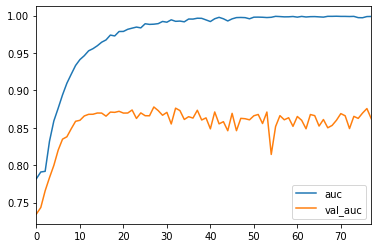

In [11]:
dfp = pd.DataFrame(clf._performance.history)[['auc', 'val_auc']].iloc[:100]
dfp.plot()

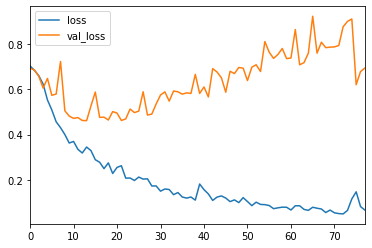

In [12]:
dfp = pd.DataFrame(clf._performance.history)[['loss', 'val_loss']].iloc[:100]
dfp.plot()

In [13]:
clf._performance.evaluate(trainX, trainY) # RMSE, R^2

[0.9885136025294777]

In [14]:
clf._performance.evaluate(validX, validY) # RMSE, R^2

[0.8778518778518778]

In [15]:
clf._performance.evaluate(testX, testY) # RMSE, R^2

[0.8954901960784314]

In [16]:
clf._performance.model.save('./model.h5')